In [1]:
# load functions for data analysis
from scr_analysis_functions_fyp import experimental, visualizeStats
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf    
import pandas, os, scipy
import seaborn as sns
import numpy as np

% pylab inline
pandas.options.mode.chained_assignment = None

Populating the interactive namespace from numpy and matplotlib


In [2]:
data_path = '/Users/biota/Desktop/sSL/repo/analysis/data_physio_study1'

In [3]:
day_one = experimental(data_path)
day_one.day = 1
day_one.preprocessData()

In [4]:
day_two = experimental(data_path)
day_two.day = 2
day_two.preprocessData()

In [418]:
def counterbalance_info(_data_): 
    
    cb, bc, order = [], [], np.zeros(_data_.nSubjects)

    for iSubject in range(0,len(_data_.subjectNames)): 
        if str.find(_data_.subjectNames[iSubject], '_cb_') != -1: 
            cb.append(iSubject)
        else: 
            bc.append(iSubject)

    cb = np.array(cb)
    bc = np.array(bc)
    order[cb] = 1

    return order, bc, cb

In [431]:
order, bc, cb = counterbalance_info(day_two)

In [437]:
this = {'a':[]}

In [441]:
this['v'] = []

In [450]:
def extract_conditioning_data(_data_, _type_, _dict_=''):
    '''
    _data_ is either day_one or day_two
    _type_ is either onset (predictive) or offset (contagion)
    '''
    if not _dict_: _dict_ = {}
    
    _positive_ = np.zeros([_data_.nSubjects,len(range(3,12))])
    _negative_ = np.zeros([_data_.nSubjects,len(range(3,12))])

    _trial_ = list(range(3,12))
    for iStim in range(0,len(conditioning)):
        _positive_[:,iStim], _negative_[:,iStim] = _data_.amplitudeDifference('trans', _trial_[iStim], _type_);

    _significance_ = np.zeros(_data_.nSubjects)
    for iSubject in range(0,_data_.nSubjects): 
        _significance_[iSubject] = scipy.stats.ttest_ind(_positive_[iSubject,:], _negative_[iSubject,:])[1];
        

    _dict_['%s_plus'%_type_] = _positive_
    _dict_['%s_minus'%_type_] = _negative_
    _dict_['%s_significance'%_type_] = _significance_
    
    return _dict_

In [451]:
conditioning = extract_conditioning_data(day_one, 'onset')
conditioning = extract_conditioning_data(day_one, 'offset', conditioning)

In [452]:
conditioning.keys()

['offset_minus',
 'onset_significance',
 'offset_significance',
 'onset_minus',
 'offset_plus',
 'onset_plus']

In [9]:
start_con_onsets = 4
end_con_onsets   = 13
conditioning_pos_onsets = np.zeros([day_one.nSubjects,len(range(start_con_onsets,end_con_onsets))])
conditioning_neg_onsets = np.zeros([day_one.nSubjects,len(range(start_con_onsets,end_con_onsets))])

day_one.nSeconds = 4.5
conditioning = list(range(start_con_onsets,end_con_onsets))

for i_stim in range(0,len(conditioning)):
    conditioning_pos_onsets[:,i_stim], conditioning_neg_onsets[:,i_stim] = day_one.amplitudeDifference('trans',
                                                                           conditioning[i_stim],
                                                                           'onset');
conditioning_significance_onsets = np.zeros(day_one.nSubjects)

for i_subject in range(0,day_one.nSubjects): 
    conditioning_significance_onsets[i_subject] = scipy.stats.wilcoxon(conditioning_pos_onsets[i_subject,:],
                                                                 conditioning_neg_onsets[i_subject,:])[1];

In [11]:

iStim = 0
day_two.nSeconds = 4.5
renewal_plus, renewal_minus = day_two.amplitudeDifference('trans',iStim,'onset');


In [12]:
log_conditioning_pos_onsets = log(1 + conditioning_pos_onsets)
log_conditioning_neg_onsets = log(1 + conditioning_neg_onsets)
log_renewal_plus = log(1 + renewal_plus)
log_renewal_minus = log(1 + renewal_minus)

log_learning = mean(log_conditioning_pos_onsets - log_conditioning_neg_onsets,1)
log_renewal =  log_renewal_plus - log_renewal_minus 

In [402]:
# tmp_alpha = .2
# sns.set_style("dark", {'axes.grid' : True})
# scatter(np.ones(sum(order==True)), log_renewal_minus[order==True], color='blue',alpha=tmp_alpha)
# scatter(np.ones(sum(order==True))+1, log_renewal_plus[order==True], color='red',alpha=tmp_alpha)

# tmp_len = len(np.nonzero(order==False)[0])
# scatter(np.ones(tmp_len), log_renewal_minus[order==False], color='blue',alpha=tmp_alpha)
# scatter(np.ones(tmp_len)+1, log_renewal_plus[order==False], color='red',alpha=tmp_alpha)

# xlim(.5,2.5) ; ylim(-.3,2.3); 

In [16]:
order_effects = pandas.DataFrame({'renewal':log_renewal, 'order':order}) 
formula = 'renewal ~ order'
model = ols(formula, SCR_all).fit()
aov_table = anova_lm(model, typ=2)
print '\n\t\t', formula, '\n\n', aov_table, '\n\n'
p_val_order_effects = aov_table.values[0,3]


		renewal ~ order 

             sum_sq    df          F    PR(>F)
order      8.160960   1.0  16.541136  0.000199
Residual  21.215065  43.0        NaN       NaN 




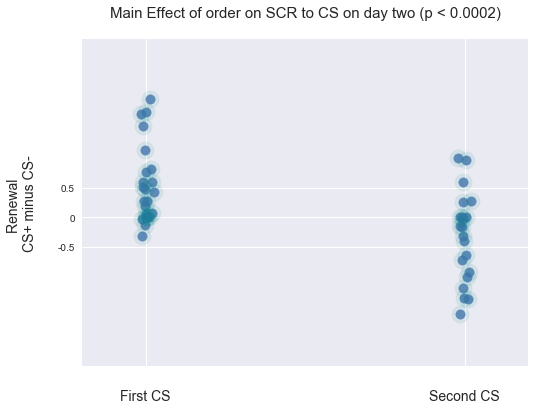

In [404]:

figure(figsize=[8,6])
sns.set_style("dark", {'axes.grid' : True})
jitter = np.random.randn(len(order))/100
scatter(order + jitter,log_renewal, alpha=.8, s=90)
scatter(order + jitter,log_renewal, color='darkcyan', alpha=.1, s=300)
ylabel('Renewal \nCS+ minus CS-\n', rotation=90, fontsize=14)

yticks([-.5,0,.5,],[-.5,0,.5])
xticks([0, 1],['\nFirst CS','\nSecond CS'], fontsize=14)
xlim(-.2, 1.2)
ylim(-2.5, 3)
title('Main Effect of order on SCR to CS on day two (p < %.04f)\n'%p_val_order_effects, fontsize=15); 


In [15]:

SCR_all = pandas.DataFrame({'renewal':log_renewal, 'prediction':log_learning, 'order':order}) 


In [221]:
start_con_onsets, end_con_onsets = 4, 13

conditioning_pos_onsets_raw = np.zeros([day_one.nSubjects,len(range(start_con_onsets,end_con_onsets))])
conditioning_neg_onsets_raw = np.zeros([day_one.nSubjects,len(range(start_con_onsets,end_con_onsets))])

day_one.nSeconds = 4.5
conditioning_inds = list(range(start_con_onsets, end_con_onsets))

for i_stim in range(0,len(conditioning_inds)):
    conditioning_pos_onsets_raw[:,i_stim], conditioning_neg_onsets_raw[:,i_stim] = day_one.amplitudeDifference('raw',
                                                                                   conditioning_inds[i_stim],
                                                                                   'onset');

In [222]:
start_con_onsets, end_con_onsets = 4, 13

conditioning_pos_offsets_raw = np.zeros([day_one.nSubjects,len(range(start_con_onsets,end_con_onsets))])
conditioning_neg_offsets_raw = np.zeros([day_one.nSubjects,len(range(start_con_onsets,end_con_onsets))])

day_one.nSeconds = 4.5
conditioning_inds = list(range(start_con_onsets, end_con_onsets))

for i_stim in range(0,len(conditioning_inds)):
    conditioning_pos_offsets_raw[:,i_stim], conditioning_neg_offsets_raw[:,i_stim] = day_one.amplitudeDifference('raw',
                                                                                   conditioning_inds[i_stim],
                                                                                   'offset');

In [18]:
day_two.nSeconds = 4.5
raw_renewal_plus, raw_renewal_minus = day_two.amplitudeDifference('raw',0,'onset');

In [323]:
#responders = np.array(mean(conditioning_pos_onsets_raw,1) > .00)

In [324]:
responders = np.array(conditioning_pos_onsets_raw > .1).mean(1) > 0
#responders = np.array((conditioning_pos_offsets_raw) > .1).mean(1) > 0

In [325]:
SCR = pandas.DataFrame({'renewal':log_renewal[responders], 
                        'prediction':log_learning[responders], 
                        'order':order[responders]})

In [326]:

formula = 'renewal ~ prediction'
model_prediction_responders = ols(formula, SCR).fit()
aov_table_responders = anova_lm(model_prediction_responders, typ=2)
print '\n\n\t\t', formula, '\n\n', aov_table_responders

formula = 'renewal ~ prediction + C(order)'
model_prediction_order_responders = ols(formula, SCR).fit()
aov_table_order_responders = anova_lm(model_prediction_order_responders, typ=2)
p_value = aov_table_order_responders.values[2,3]
print '\n\n\t', formula, '\n\n', aov_table_order_responders, '\n\n'

p_value_responders_order_prediction = aov_table_order_responders.values[1,3]
p_value_responders_prediction = aov_table_responders.values[0,3]



		renewal ~ prediction 

               sum_sq    df          F    PR(>F)
prediction   6.568438   1.0  10.689172  0.002855
Residual    17.205848  28.0        NaN       NaN


	renewal ~ prediction + C(order) 

               sum_sq    df          F    PR(>F)
C(order)     6.383237   1.0  15.924754  0.000454
prediction   2.819733   1.0   7.034604  0.013222
Residual    10.822610  27.0        NaN       NaN 




In [327]:
SCR['contagion_learning'] = contagion_learning[responders]
formula = 'renewal ~ contagion_learning'
contagion_model = ols(formula, SCR).fit()
aov_table_contagion = anova_lm(contagion_model, typ=2)
p_value_contagion = aov_table_contagion.values[0,3]
print '\n\n\t', formula, '\n\n', aov_table_contagion, '\n\n'


log_conditioning_pos_offsets = log(1 + conditioning_pos_offsets)
log_conditioning_neg_offsets = log(1 + conditioning_neg_offsets)

contagion_learning = mean(log_conditioning_pos_offsets - log_conditioning_neg_offsets,1)#
cb = np.nonzero(order[responders])[0]

SCR['contagion_learning'] = contagion_learning[responders]
formula = 'renewal ~ contagion_learning + C(order)'
contagion_model = ols(formula, SCR).fit()
aov_table_contagion = anova_lm(contagion_model, typ=2)
p_value_contagion = aov_table_contagion.values[1,3]
print '\n\n\t', formula, '\n\n', aov_table_contagion, '\n\n'




	renewal ~ contagion_learning 

                       sum_sq    df         F    PR(>F)
contagion_learning   0.192911   1.0  0.229059  0.635939
Residual            23.581374  28.0       NaN       NaN 




	renewal ~ contagion_learning + C(order) 

                       sum_sq    df          F    PR(>F)
C(order)            10.387908   1.0  21.258515  0.000087
contagion_learning   0.448876   1.0   0.918611  0.346344
Residual            13.193467  27.0        NaN       NaN 




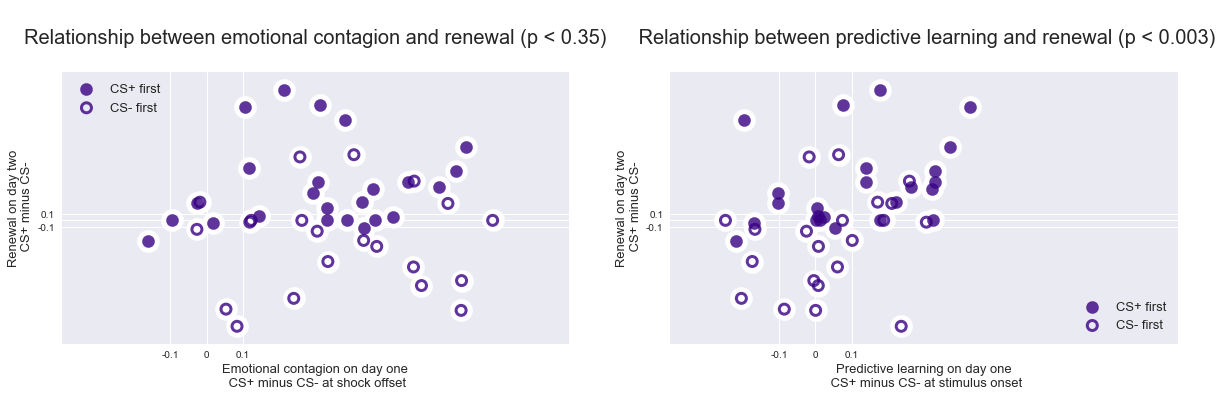

In [328]:
figure(figsize=[20,5])
sns.set_style("dark", {'axes.grid' : True})
subplot(121)
type_color = 'xkcd:indigo'
scatter(contagion_learning, log_renewal,color='xkcd:white',alpha=1,s=500)
scatter(contagion_learning[order == False], log_renewal[order == False],color=type_color,alpha=.8,s=150, label='CS+ first')
scatter(contagion_learning[order == True], log_renewal[order == True], color=type_color,alpha=.8, s=100,  label='CS- first', linewidth=3, facecolor='none')

yticks([-.1,0,.1],[-.1,'',.1])
xticks([-.1,0,.1],[-.1,0,.1])

legend(loc=2, fontsize=13)
xlabel('Emotional contagion on day one\n CS+ minus CS- at shock offset',fontsize=13)
ylabel('Renewal on day two\n CS+ minus CS-',fontsize=13)
xlim(-.4,1)
title('Relationship between emotional contagion and renewal (p < %.02f)\n' 
      %(p_value_contagion), fontsize=20); 

subplot(122)
type_color = 'xkcd:indigo'
scatter(log_learning, log_renewal,color='xkcd:white',alpha=1,s=500)
#scatter(log_learning[responders == True], log_renewal[responders == True],color='yellow',alpha=1,s=300, label='responders')

scatter(log_learning[order == False], log_renewal[order == False],color=type_color,alpha=.8,s=150, label='CS+ first')
scatter(log_learning[order == True], log_renewal[order == True], color=type_color,alpha=.8, s=100,  label='CS- first', linewidth=3, facecolor='none')

yticks([-.1,0,.1],[-.1,'',.1])
xticks([-.1,0,.1],[-.1,0,.1])

legend(loc=4, fontsize=13)
xlabel('Predictive learning on day one\n CS+ minus CS- at stimulus onset',fontsize=13)
ylabel('Renewal on day two\n CS+ minus CS-',fontsize=13)
xlim(-.4,1)
title('\n Relationship between predictive learning and renewal (p < %.03f)\n' 
      %(p_value_responders_prediction), fontsize=20); 

In [380]:
conditioning_significance_raw_onsets = np.zeros(day_one.nSubjects)

for i_subject in range(0,day_one.nSubjects): 
    conditioning_significance_raw_onsets[i_subject] = scipy.stats.ttest_ind(conditioning_pos_onsets_raw[i_subject,:],
                                                                 conditioning_neg_onsets_raw[i_subject,:])[1];

In [405]:
mean_cutoff = conditioning_significance_raw_onsets.mean()
conditioned_subjects_= find(conditioning_significance_onsets < mean_cutoff)

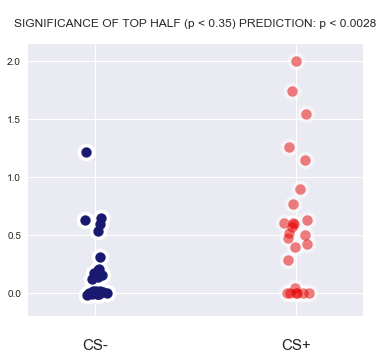

In [406]:
figure(figsize=[6,5])
sns.set_style("dark", {'axes.grid' : True})
#scatter(order[cb], log_renewal_plus[cb])
tmp_len_p = len(log_renewal_plus[conditioned_subjects_])
tmp_len_n = len(log_renewal_minus[conditioned_subjects_])
jitter_p = np.random.randn(tmp_len_p)/100
jitter_n = np.random.randn(tmp_len_n)/100

_results_ = scipy.stats.ttest_ind(log_renewal_plus[conditioned_subjects_], log_renewal_minus[conditioned_subjects_])

scatter(np.zeros(tmp_len_p)+ .3 + jitter_p, log_renewal_plus[conditioned_subjects_],s=300, alpha=.5,color='white') 
scatter(np.zeros(tmp_len_p)+ .3 + jitter_p, log_renewal_plus[conditioned_subjects_],s=100, alpha=.5,color='xkcd:red') 
scatter(np.zeros(tmp_len_n)+jitter_n, log_renewal_minus[conditioned_subjects_]+ jitter_p,s=300, alpha=1, color='white') 
scatter(np.zeros(tmp_len_n)+jitter_n, log_renewal_minus[conditioned_subjects_]+ jitter_p,s=100, alpha=1, color='midnightblue') 
xlim([-.1,.4])
#ylim(-.2,1)
xticks([0,.3], ['\nCS-', '\nCS+'], fontsize=15); 
#yticks([0,.5], [], fontsize=15); 
title('\nSIGNIFICANCE OF TOP HALF (p < %.2f) PREDICTION: p < %.4f\n'%(mean_cutoff, _results_.pvalue)); 

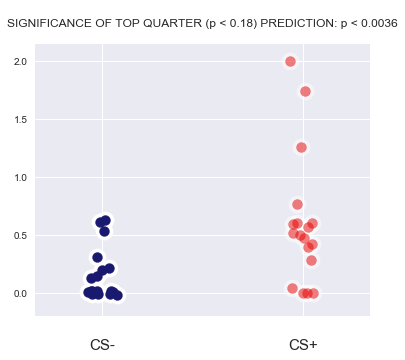

In [409]:
top_25 = (conditioning_significance_raw_onsets.mean() + conditioning_significance_raw_onsets.min())/2

conditioned_subjects_= find(conditioning_significance_onsets < top_25)


figure(figsize=[6,5])
sns.set_style("dark", {'axes.grid' : True})
#scatter(order[cb], log_renewal_plus[cb])
tmp_len_p = len(log_renewal_plus[conditioned_subjects_])
tmp_len_n = len(log_renewal_minus[conditioned_subjects_])
jitter_p = np.random.randn(tmp_len_p)/100
jitter_n = np.random.randn(tmp_len_n)/100

_results_ = scipy.stats.ttest_ind(log_renewal_plus[conditioned_subjects_], log_renewal_minus[conditioned_subjects_])

scatter(np.zeros(tmp_len_p)+ .3 + jitter_p, log_renewal_plus[conditioned_subjects_],s=300, alpha=.5,color='white') 
scatter(np.zeros(tmp_len_p)+ .3 + jitter_p, log_renewal_plus[conditioned_subjects_],s=100, alpha=.5,color='xkcd:red') 
scatter(np.zeros(tmp_len_n)+jitter_n, log_renewal_minus[conditioned_subjects_]+ jitter_p,s=300, alpha=1, color='white') 
scatter(np.zeros(tmp_len_n)+jitter_n, log_renewal_minus[conditioned_subjects_]+ jitter_p,s=100, alpha=1, color='midnightblue') 
xlim([-.1,.4])
#ylim(-.2,1)
xticks([0,.3], ['\nCS-', '\nCS+'], fontsize=15); 
#yticks([0,.5], [], fontsize=15); 
title('\nSIGNIFICANCE OF TOP QUARTER (p < %.2f) PREDICTION: p < %.4f\n'%(top_25, _results_.pvalue)); 


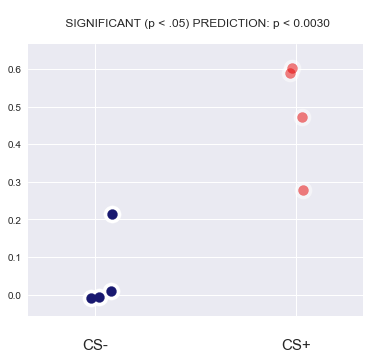

In [410]:
conditioned_subjects_= find(conditioning_significance_onsets < .05)

figure(figsize=[6,5])
sns.set_style("dark", {'axes.grid' : True})
#scatter(order[cb], log_renewal_plus[cb])
tmp_len_p = len(log_renewal_plus[conditioned_subjects_])
tmp_len_n = len(log_renewal_minus[conditioned_subjects_])
jitter_p = np.random.randn(tmp_len_p)/80
jitter_n = np.random.randn(tmp_len_n)/80

_results_ = scipy.stats.ttest_ind(log_renewal_plus[conditioned_subjects_], log_renewal_minus[conditioned_subjects_])

scatter(np.zeros(tmp_len_p)+ .3 + jitter_p, log_renewal_plus[conditioned_subjects_],s=300, alpha=.5,color='white') 
scatter(np.zeros(tmp_len_p)+ .3 + jitter_p, log_renewal_plus[conditioned_subjects_],s=100, alpha=.5,color='xkcd:red') 
scatter(np.zeros(tmp_len_n)+jitter_n, log_renewal_minus[conditioned_subjects_]+ jitter_p,s=300, alpha=1, color='white') 
scatter(np.zeros(tmp_len_n)+jitter_n, log_renewal_minus[conditioned_subjects_]+ jitter_p,s=100, alpha=1, color='midnightblue') 
xlim([-.1,.4])
#ylim(-.2,1)
xticks([0,.3], ['\nCS-', '\nCS+'], fontsize=15); 
#yticks([0,.5], [], fontsize=15); 
title('\n SIGNIFICANT (p < .05) PREDICTION: p < %.4f\n'%_results_.pvalue); 

In [371]:
conditioning_significance_raw_offsets = np.zeros(day_one.nSubjects)

for i_subject in range(0,day_one.nSubjects): 
    conditioning_significance_raw_offsets[i_subject] = scipy.stats.ttest_ind(conditioning_pos_offsets_raw[i_subject,:],
                                                                 conditioning_neg_offsets_raw[i_subject,:])[1];

In [411]:
top_half = conditioning_significance_raw_offsets.mean()
conditioned_subjects_offsets_ = find(conditioning_significance_offsets < top_half)

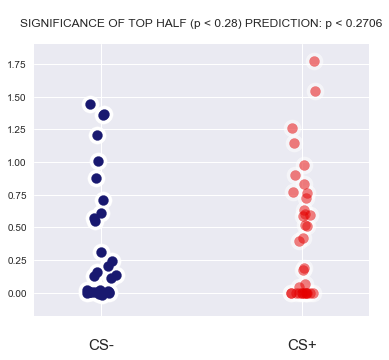

In [413]:
figure(figsize=[6,5])
sns.set_style("dark", {'axes.grid' : True})
#scatter(order[cb], log_renewal_plus[cb])
tmp_len_p = len(log_renewal_plus[conditioned_subjects_offsets_])
tmp_len_n = len(log_renewal_minus[conditioned_subjects_offsets_])
jitter_p = np.random.randn(tmp_len_p)/100
jitter_n = np.random.randn(tmp_len_n)/100

_results_ = scipy.stats.ttest_ind(log_renewal_plus[conditioned_subjects_offsets_], 
                                  log_renewal_minus[conditioned_subjects_offsets_])

scatter(np.zeros(tmp_len_p)+ .3 + jitter_p, log_renewal_plus[conditioned_subjects_offsets_],s=300, alpha=.5,color='white') 
scatter(np.zeros(tmp_len_p)+ .3 + jitter_p, log_renewal_plus[conditioned_subjects_offsets_],s=100, alpha=.5,color='xkcd:red') 
scatter(np.zeros(tmp_len_n)+jitter_n, log_renewal_minus[conditioned_subjects_offsets_]+ jitter_p,s=300, alpha=1, color='white') 
scatter(np.zeros(tmp_len_n)+jitter_n, log_renewal_minus[conditioned_subjects_offsets_]+ jitter_p,s=100, alpha=1, color='midnightblue') 
xlim([-.1,.4])
#ylim(-.2,1)
xticks([0,.3], ['\nCS-', '\nCS+'], fontsize=15); 
#yticks([0,.5], [], fontsize=15); 
title('\nSIGNIFICANCE OF TOP HALF (p < %.2f) PREDICTION: p < %.4f\n'%(top_half, _results_.pvalue)); 

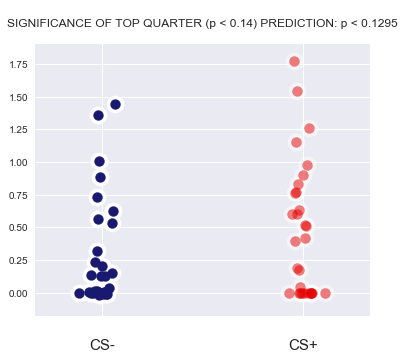

In [414]:
top_25 = (conditioning_significance_raw_offsets.mean() + conditioning_significance_raw_offsets.min())/2

conditioned_subjects_= find(conditioning_significance_offsets < top_25)


figure(figsize=[6,5])
sns.set_style("dark", {'axes.grid' : True})
#scatter(order[cb], log_renewal_plus[cb])
tmp_len_p = len(log_renewal_plus[conditioned_subjects_])
tmp_len_n = len(log_renewal_minus[conditioned_subjects_])
jitter_p = np.random.randn(tmp_len_p)/100
jitter_n = np.random.randn(tmp_len_n)/100

_results_ = scipy.stats.ttest_ind(log_renewal_plus[conditioned_subjects_], log_renewal_minus[conditioned_subjects_])

scatter(np.zeros(tmp_len_p)+ .3 + jitter_p, log_renewal_plus[conditioned_subjects_],s=300, alpha=.5,color='white') 
scatter(np.zeros(tmp_len_p)+ .3 + jitter_p, log_renewal_plus[conditioned_subjects_],s=100, alpha=.5,color='xkcd:red') 
scatter(np.zeros(tmp_len_n)+jitter_n, log_renewal_minus[conditioned_subjects_]+ jitter_p,s=300, alpha=1, color='white') 
scatter(np.zeros(tmp_len_n)+jitter_n, log_renewal_minus[conditioned_subjects_]+ jitter_p,s=100, alpha=1, color='midnightblue') 
xlim([-.1,.4])
#ylim(-.2,1)
xticks([0,.3], ['\nCS-', '\nCS+'], fontsize=15); 
#yticks([0,.5], [], fontsize=15); 
title('\nSIGNIFICANCE OF TOP QUARTER (p < %.2f) PREDICTION: p < %.4f\n'%(top_25, _results_.pvalue)); 

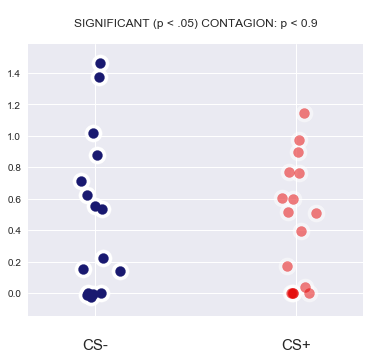

In [415]:
conditioned_subjects_= find(conditioning_significance_offsets < .05)

figure(figsize=[6,5])
sns.set_style("dark", {'axes.grid' : True})
#scatter(order[cb], log_renewal_plus[cb])
tmp_len_p = len(log_renewal_plus[conditioned_subjects_])
tmp_len_n = len(log_renewal_minus[conditioned_subjects_])
jitter_p = np.random.randn(tmp_len_p)/80
jitter_n = np.random.randn(tmp_len_n)/80

_results_ = scipy.stats.ttest_ind(log_renewal_plus[conditioned_subjects_], log_renewal_minus[conditioned_subjects_])

scatter(np.zeros(tmp_len_p)+ .3 + jitter_p, log_renewal_plus[conditioned_subjects_],s=300, alpha=.5,color='white') 
scatter(np.zeros(tmp_len_p)+ .3 + jitter_p, log_renewal_plus[conditioned_subjects_],s=100, alpha=.5,color='xkcd:red') 
scatter(np.zeros(tmp_len_n)+jitter_n, log_renewal_minus[conditioned_subjects_]+ jitter_p,s=300, alpha=1, color='white') 
scatter(np.zeros(tmp_len_n)+jitter_n, log_renewal_minus[conditioned_subjects_]+ jitter_p,s=100, alpha=1, color='midnightblue') 
xlim([-.1,.4])
#ylim(-.2,1)
xticks([0,.3], ['\nCS-', '\nCS+'], fontsize=15); 
#yticks([0,.5], [], fontsize=15); 
title('\nSIGNIFICANT (p < .05) CONTAGION: p < %.1f\n'%_results_.pvalue); 

In [86]:
import behavioral_analysis_functions_fyp as ba_fun
self_report, subject_names = ba_fun.generate_data_frame()
# ba_fun.correlation_matrix(self_report)

SyntaxError: invalid syntax (<ipython-input-86-63fbc23688f0>, line 1)

In [170]:

SCR_all = pandas.DataFrame({'renewal':log_renewal, 'prediction':log_learning, 'order':order}) 
SCR_all['subject_names'] = [day_two.subjectNames[ii][0:4] for ii in range(day_two.nSubjects)]

In [171]:
for ii in range(len(SCR_all)): 
    name = SCR_all.subject_names.values[ii]
    found = 0
    for jj in range(len(self_report)): 
        if name in self_report.index.values[jj]: 
            found = 1
    if found == 0 : 
        missing_subject = ii

In [172]:
SCR_all = SCR_all.drop(missing_subject)

In [173]:
tmp_data = {}
indices = [] 
for ii in range(len(SCR_all.keys())): 
    tmp_data[SCR_all.keys()[ii]] = SCR_all[SCR_all.keys()[ii]].values

for ii in range(len(self_report.keys())): 
    tmp_data[self_report.keys()[ii]] = self_report[self_report.keys()[ii]].values

In [174]:
physio_selfreport = pandas.DataFrame.from_dict(tmp_data)

In [175]:
cols = physio_selfreport.columns
cols = cols.map(lambda x: x.replace(' ', '_') if isinstance(x, (str, unicode)) else x)
physio_selfreport.columns = cols

cols = physio_selfreport.columns
cols = cols.map(lambda x: x.replace(':', '') if isinstance(x, (str, unicode)) else x)
physio_selfreport.columns = cols

In [176]:
#shorter_conditioning = np.delete(conditioning_significance_onsets, missing_subject) 
#physio_selfreport['conditioned_subjects'] = shorter_conditioning 

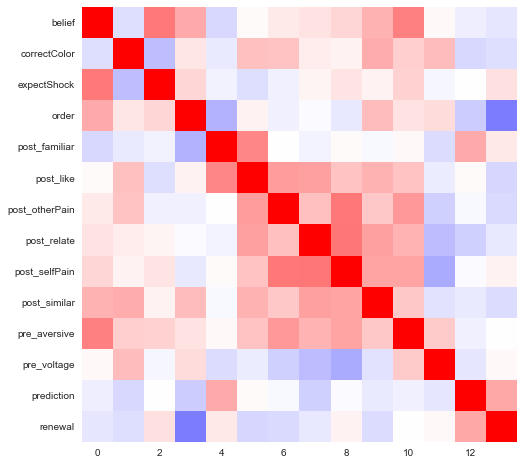

In [177]:
figure(figsize=[8,8])
sns.set_style("dark", {'axes.grid' : False})
whole_corr = physio_selfreport.corr()
imshow(whole_corr, cmap='bwr', vmax=1, vmin=-1)
yticks(range(0,len(whole_corr.keys())),whole_corr.keys()); 

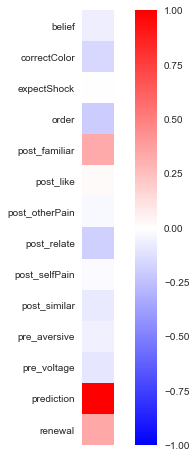

In [178]:
figure(figsize=[8,8])
sns.set_style("dark", {'axes.grid' : False})
imshow(whole_corr[-2:-1].T, cmap='bwr', vmax=1, vmin=-1)
yticks(range(len(whole_corr.keys())),whole_corr.keys()); 
colorbar() ; xticks([]); 

In [180]:
formula = 'renewal ~ pre_voltage + post_selfPain + pre_aversive'
model = ols(formula, physio_selfreport).fit()
aov_table = anova_lm(model, typ=2)
print '\n\n', formula, '\n\n', aov_table



renewal ~ pre_voltage + post_selfPain + pre_aversive 

                  sum_sq    df         F    PR(>F)
pre_voltage     0.102459   1.0  0.146120  0.704295
post_selfPain   0.155628   1.0  0.221947  0.640120
pre_aversive    0.035841   1.0  0.051115  0.822286
Residual       28.047810  40.0       NaN       NaN


In [183]:
formula = 'renewal ~ expectShock + post_otherPain + post_relate + post_similar + post_like'
model = ols(formula, physio_selfreport).fit()
aov_table = anova_lm(model, typ=2)
print '\n\n\t\t', formula, '\n\n', aov_table



		renewal ~ expectShock + post_otherPain + post_relate + post_similar + post_like 

                   sum_sq    df         F    PR(>F)
expectShock      0.319587   1.0  0.453020  0.504977
post_otherPain   0.153892   1.0  0.218145  0.643124
post_relate      0.002122   1.0  0.003008  0.956548
post_similar     0.210123   1.0  0.297854  0.588421
post_like        0.134548   1.0  0.190724  0.664786
Residual        26.807376  38.0       NaN       NaN


In [235]:
formula = 'prediction ~ post_familiar'
model = ols(formula, physio_selfreport).fit()
aov_table = anova_lm(model, typ=2)
print '\n\n\t\t', formula, '\n\n', aov_table



		prediction ~ post_familiar 

                 sum_sq    df         F    PR(>F)
post_familiar  0.152491   1.0  5.239257  0.027178
Residual       1.222431  42.0       NaN       NaN


In [238]:
formula = 'renewal ~ correctColor'
model = ols(formula, physio_selfreport).fit()
aov_table = anova_lm(model, typ=2)
print '\n\n\t\t', formula, '\n\n', aov_table



		renewal ~ correctColor 

                 sum_sq    df        F    PR(>F)
correctColor   0.449839   1.0  0.68009  0.414215
Residual      27.780500  42.0      NaN       NaN


In [78]:


#
#
#
# review: 
#        tie the intro ideas into the measures: three variables per person 
#        overall renewal renewal? 
#        -- uphill battle ... 
#        even controlling for that we still get it 
#        what is it about their experience on day one ... ? 
#        -- learning? (onset)
#        -- contagion? (offset)
#        -- argues against a lean emotional contagion model 
#        what is it? not behavioral things
#        
#
#
